Le programme notebook est séparé en plusieurs parties :    
-Les variables utiles et modifiables pour les programmes suivants      
-Les bibliothèques    
-Les fonctions avcec outil utilisé, définition et fonction    
-L'exécution des fonctions


# 1. Paramètres importants :

In [20]:

tickers = ['WMT', 'ALV', 'CRWD', 'MKTX', 'NEE', 'NVDA', 'RELI']  # Liste des actions à suivre
initial_investment = 1_000_000  # Montant investis (xxx_xxx_xxx)


# Pour la majorité des fonctions
start_date = '2015-01-01'   # Date de début de la période analysée (format YYYY-MM-DD)
end_date = '2025-04-04'     # Date de fin de la période analysée (format YYYY-MM-DD)

# Ratio de Sharpe 
risk_free_rate = 0.03  # 3% annuel

# Drawdown
nb_jours = 100              # Nombre de jours simulés
rendement_moyen = 0.001     # Rendement journalier moyen simulé
volatilite_simulee = 0.02   # Volatilité journalière pour les simulations
prix_initial = 100          # Prix de départ du portefeuille
graine = 42                 # Pour reproduire les mêmes résultats

# VaR
z_score_95 = 1.65  # Pour une distribution normale

indice = '^GSPC'  # S&P 500. Peut être changé par '^FCHI' (CAC 40), etc.



## Bibliothèques :

In [4]:
import seaborn as sns             # Pour créer des heatmaps plus esthétiques
import yfinance as yf             # Pour télécharger les données financières
import numpy as np                # Pour le calcul des rendements log
import pandas as pd               # Pour la manipulation des données
import matplotlib.pyplot as plt   # Pour tracer les rendements

# 2. Les Fonctions Python, Définitions et Formules :

---
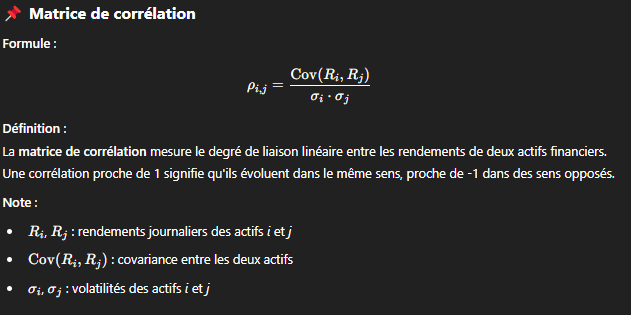

In [5]:
def afficher_matrice_correlation(tickers, start_date, end_date):
    
    # Téléchargement des données boursières
    data = yf.download(tickers, start=start_date, end=end_date)

    # Vérifie que les données contiennent bien les prix de clôture
    if 'Close' not in data.columns:
        raise KeyError("Les données téléchargées ne contiennent pas de colonnes 'Close'.")

    # Extraction des prix de clôture
    close_prices = data['Close']

    # Calcul des rendements journaliers
    returns = close_prices.pct_change().dropna()

    # Matrice de corrélation
    correlation_matrix = returns.corr()

    # Affichage de la heatmap
    plt.figure(figsize=(10, 8))  # Taille du graphique
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)  # Heatmap avec annotations
    plt.title("Corrélation des rendements journaliers")  # Titre du graphique
    plt.show()  # Affiche le graphique


---
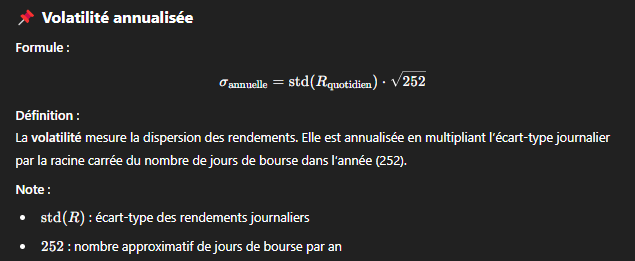

In [6]:
def calculer_volatilite(indice, start_date, end_date):

    # 1. Récupération des données de marché
    data = yf.download(indice, start=start_date, end=end_date)

    # 2. Calcul des rendements logarithmiques quotidiens
    data['log_returns'] = np.log(data['Close'] / data['Close'].shift(1))

    # 3. Suppression des valeurs nulles
    returns = data['log_returns'].dropna()

    # 4. Calcul de la volatilité annualisée
    volatility = returns.std() * np.sqrt(252)

    # 5. Affichage du résultat
    print(f"Volatilité annualisée de l’indice {indice} entre {start_date} et {end_date} : {volatility:.2%}")

    # 6. Affichage des rendements log
    returns.plot(title=f'Rendements Logarithmiques Quotidiens - {indice}')
    plt.xlabel("Date")
    plt.ylabel("Log returns")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
def calculer_volatilite_sans_graph(indice, start_date, end_date): 
    # Avec retour sous forma 0.5 pour 50% de volatilité

    # 1. Récupération des données de marché
    data = yf.download(indice, start=start_date, end=end_date)
    
    # 2. Calcul des rendements logarithmiques quotidiens
    data['log_returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # 3. Suppression des valeurs nulles
    returns = data['log_returns'].dropna()
    
    # 4. Calcul de la volatilité annualisée
    volatility = returns.std() * np.sqrt(252)
    
    # 5. Affichage du résultat
    return volatility  # Retourne la volatilité sans afficher le graphique



---
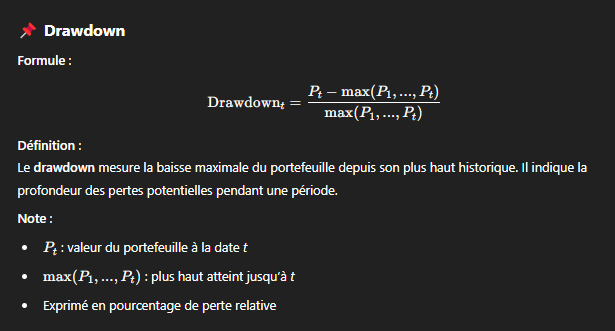

In [14]:
def simuler_drawdown(nb_jours=100, rendement_moyen=0.001, volatilite=calculer_volatilite_sans_graph(indice, start_date, end_date), prix_initial=100, graine=42): 
    # La fontion reste a obtimiser notament pour pour le volatilité

    # 1. Simulation des rendements aléatoires
    np.random.seed(graine)
    returns = np.random.normal(loc=rendement_moyen, scale=volatilite, size=nb_jours)

    # 2. Calcul des prix simulés (valeur du portefeuille)
    prices = prix_initial * (1 + returns).cumprod()

    # 3. Maximum cumulé (plus haut historique)
    rolling_max = np.maximum.accumulate(prices)

    # 4. Calcul du drawdown
    drawdown = (prices - rolling_max) / rolling_max

    # 5. Création du DataFrame de résultats
    df = pd.DataFrame({
        'Prix': prices,
        'Max cumulatif': rolling_max,
        'Drawdown': drawdown
    })

    # 6. Affichage du graphique
    plt.figure(figsize=(12, 6))

    # Graphique 1 : prix du portefeuille
    plt.subplot(2, 1, 1)
    plt.plot(df['Prix'], label='Prix du portefeuille')
    plt.plot(df['Max cumulatif'], linestyle='--', label='Max cumulatif')
    plt.title('Évolution du portefeuille simulé')
    plt.legend()

    # Graphique 2 : drawdown
    plt.subplot(2, 1, 2)
    plt.plot(df['Drawdown'], color='red', label='Drawdown')
    plt.title('Drawdown du portefeuille')
    plt.xlabel('Jours')
    plt.ylabel('Drawdown (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed

Volatilité annualisée de l’indice ^GSPC entre 2015-01-01 et 2025-04-04 : 17.92%


---
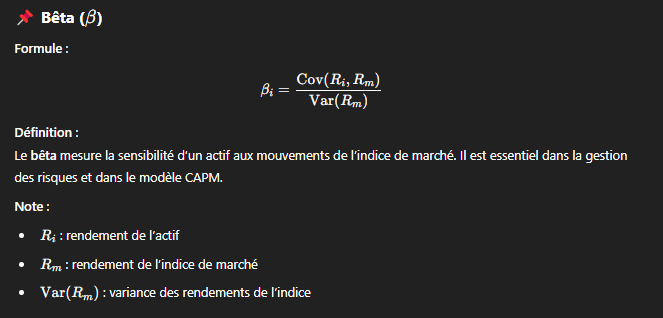

In [13]:
def calculer_betas(tickers, indice, start_date, end_date):

    # Téléchargement des données (actions + indice)
    data = yf.download(tickers + [indice], start=start_date, end=end_date)

    # Sélection de la colonne de prix ajustés si disponible, sinon prix de clôture
    if 'Adj Close' in data.columns:
        prices = data['Adj Close']
    elif 'Close' in data.columns:
        prices = data['Close']

    # Calcul des rendements journaliers
    returns = prices.pct_change().dropna()

    # Calcul des bêtas pour chaque action
    betas = {}
    for ticker in tickers:
        try:
            x = returns[indice].values          # Rendements de l’indice
            y = returns[ticker].values          # Rendements de l’action
            if len(x) > 0 and len(y) > 0:
                cov = np.cov(y, x)[0][1]        # Covariance entre action et indice
                var = np.var(x, ddof=1)         # Variance de l’indice (ddof=1 pour unbiased)
                beta = cov / var                # Formule du bêta
                betas[ticker] = beta
            else:
                betas[ticker] = np.nan
        except Exception as e:
            betas[ticker] = f"Erreur: {e}"      # Gestion d’erreur individuelle

    # Affichage du tableau des bêtas
    df_betas = pd.DataFrame.from_dict(betas, orient='index', columns=['Bêta'])
    display(df_betas)



---

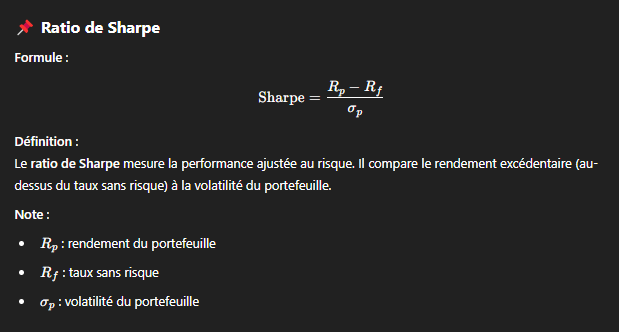

In [16]:
def calculer_sharpe_ratio(tickers, start_date, end_date, risk_free_rate):

    # 1. Téléchargement des prix
    data = yf.download(tickers, start=start_date, end=end_date)

    # 2. Choix de la bonne colonne de prix
    if 'Adj Close' in data.columns:
        prices = data['Adj Close']
    elif 'Close' in data.columns:
        prices = data['Close']
    else:
        raise KeyError("Ni 'Adj Close' ni 'Close' ne sont disponibles dans les données récupérées.")

    # 3. Calcul des rendements journaliers
    returns = prices.pct_change().dropna()

    # 4. Calcul des rendements et volatilité annualisés
    mean_returns = returns.mean() * 252            # Rendement annualisé
    volatility = returns.std() * np.sqrt(252)      # Volatilité annualisée

    # 5. Ratio de Sharpe
    sharpe_ratios = (mean_returns - risk_free_rate) / volatility

    # 6. Affichage des résultats sous forme de DataFrame
    df_sharpe = pd.DataFrame({
        'Rendement annualisé': mean_returns,
        'Volatilité annualisée': volatility,
        'Sharpe Ratio': sharpe_ratios
    })

    print(f"=== Ratio de Sharpe (avec taux sans risque de {risk_free_rate*100:.2f}%) ===")
    display(df_sharpe.round(4))


---
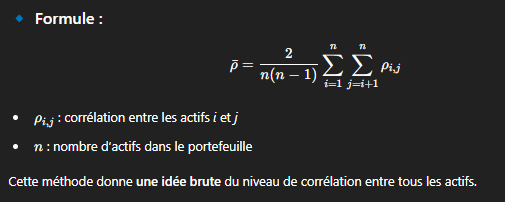

In [18]:
def corr_moyenne_simple(tickers, start_date, end_date):

    # 1. Récupération des prix ajustés automatiquement (auto_adjust=True par défaut)
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    
    # 2. Calcul des rendements quotidiens
    returns = data.pct_change().dropna()
    
    # 3. Création de la matrice de corrélation
    corr_matrix = returns.corr()
    
    # 4. Moyenne des corrélations (hors diagonale)
    mask = ~np.eye(len(tickers), dtype=bool)  # pour exclure la diagonale
    mean_corr = corr_matrix.where(mask).mean().mean()
    
    # 5. Affichage (optionnel)
    print(f"Corrélation moyenne simple du portefeuille : {mean_corr:.4f}")
    
    return mean_corr


---
# Exécution des fonctions :

[*********************100%***********************]  7 of 7 completed


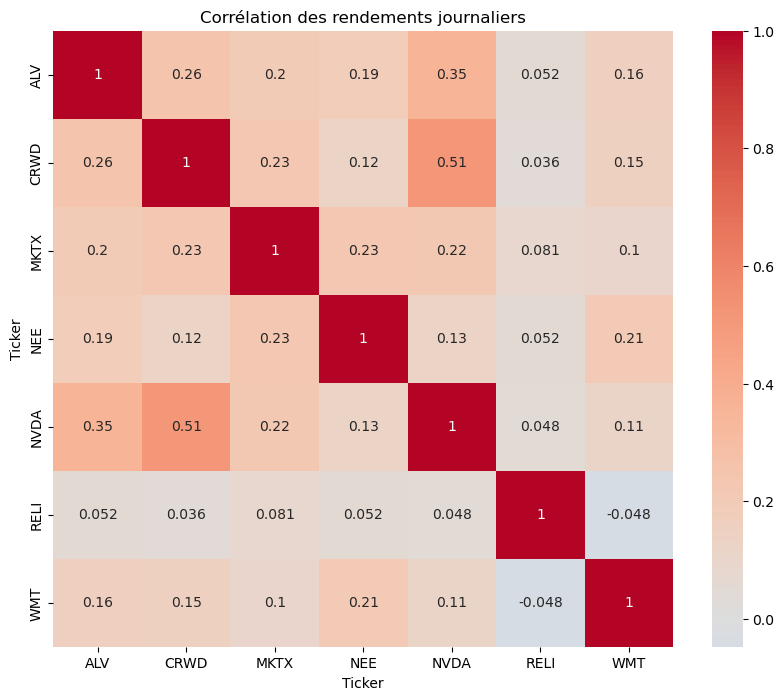

[*********************100%***********************]  1 of 1 completed


Volatilité annualisée de l’indice ^GSPC entre 2015-01-01 et 2025-04-04 : 17.92%


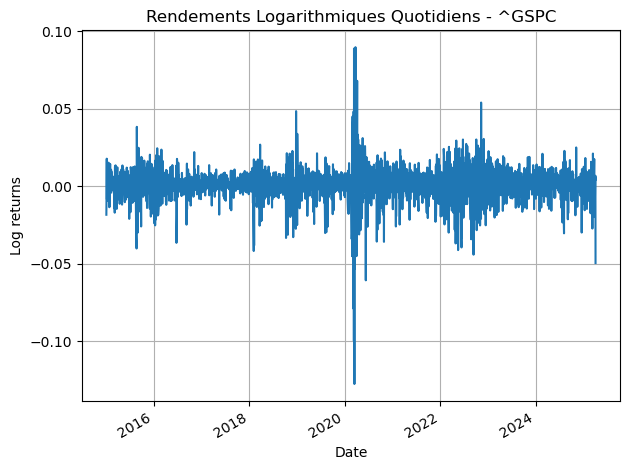

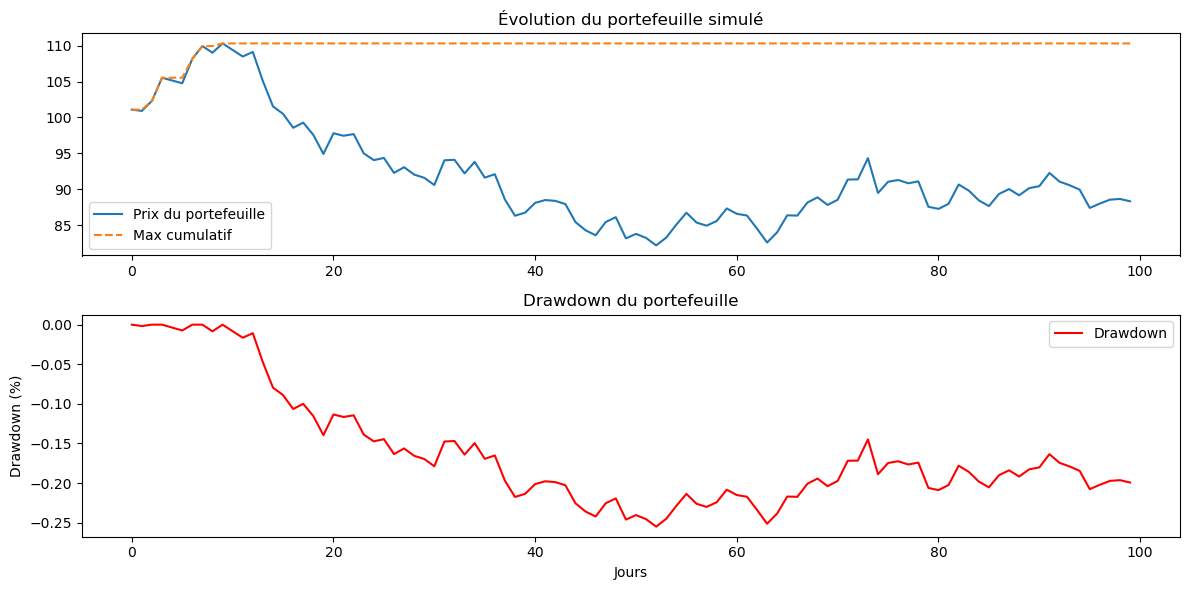

[*********************100%***********************]  8 of 8 completed


,Bêta
WMT,0.435605
ALV,1.150702
CRWD,1.655251
MKTX,0.763359
NEE,0.581590
NVDA,2.274952
RELI,0.731983


[*********************100%***********************]  7 of 7 completed

=== Ratio de Sharpe (avec taux sans risque de 3.00%) ===


,Rendement annualisé,Volatilité annualisée,Sharpe Ratio
Ticker,,,
ALV,0.0554,0.3293,0.0772
CRWD,0.2414,0.5186,0.4076
MKTX,-0.1580,0.3472,-0.5414
NEE,0.0253,0.2681,-0.0177
NVDA,0.6210,0.5405,1.0935
RELI,-0.8423,1.4763,-0.5909
WMT,0.1774,0.2043,0.7215


[*********************100%***********************]  7 of 7 completed

Corrélation moyenne simple du portefeuille : 0.1622


0.16216921610750126

In [19]:
afficher_matrice_correlation(tickers, start_date, end_date)  # Affiche la matrice de corrélation
calculer_volatilite(indice, start_date, end_date)  # Calcule la volatilité de l’indice
simuler_drawdown(nb_jours, rendement_moyen, volatilite_simulee, prix_initial, graine)  # Simule le drawdown
calculer_betas(tickers, indice, start_date, end_date)  # Calcule les bêtas
calculer_sharpe_ratio(tickers, start_date, end_date, risk_free_rate)  # Calcule le ratio de Sharpe
corr_moyenne_simple(tickers, start_date, end_date)  # Calcule la corrélation moyenne simple entre les actions

## Screener d'action 

Actuellement à l'état de test. Il faudra le faire de façon très propre adaptable à différentes stratégie, exportable excel etc...

In [ ]:
actifs = ['WMT', 'ALV', 'CRWD', 'MKTX', 'NEE', 'NVDA', 'RELI'] # Liste des actifs à analyser


# Paramètres de filtrage
parametres = {
    'pe_ratio_max': 25,
    'peg_ratio_max': 2,
    'roe_min': 0.1,
    'roa_min': 0.05,
    'debt_to_equity_max': 1.0,
    'current_ratio_min': 1.5,
    'profit_margin_min': 0.1,
    'eps_growth_min': 0.05,
    'sma_50_trend': True,
    'sma_200_trend': True,
    'volatilite_max': 0.4,
    'momentum_min': 0.02,
    'market_cap_min': 10e9,
    'market_cap_max': 2e12,
    'dividend_yield_min': 0.01,
    'price_to_book_max': 10,
    'free_cash_flow_min': 0,
    'performance_1y_min': 0.1,
    'performance_3m_min': 0.05,
    'drawdown_max': 0.25,
    'beta_max': 1.5,
}

# Fonction d’analyse
def analyse_actif(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        hist = stock.history(period="1y")

        if len(hist) < 200:
            return {'ticker': ticker, 'error': 'Pas assez d’historique'}

        # Données fondamentales
        pe_ratio = info.get("trailingPE", np.nan)
        peg_ratio = info.get("pegRatio", np.nan)
        roe = info.get("returnOnEquity", np.nan)
        roa = info.get("returnOnAssets", np.nan)
        debt_equity = info.get("debtToEquity", np.nan)
        current_ratio = info.get("currentRatio", np.nan)
        profit_margin = info.get("profitMargins", np.nan)
        eps_growth = info.get("earningsQuarterlyGrowth", np.nan)
        market_cap = info.get("marketCap", np.nan)
        dividend_yield = info.get("dividendYield", 0)
        price_to_book = info.get("priceToBook", np.nan)
        free_cash_flow = info.get("freeCashflow", 0)
        beta = info.get("beta", np.nan)

        # Performance
        perf_1y = (hist["Close"].iloc[-1] - hist["Close"].iloc[0]) / hist["Close"].iloc[0]
        perf_3m = (hist["Close"].iloc[-1] - hist["Close"].iloc[-66]) / hist["Close"].iloc[-66]
        drawdown = (hist["Close"].max() - hist["Close"].iloc[-1]) / hist["Close"].max()

        # Technique
        sma_50 = hist["Close"].rolling(50).mean().iloc[-1]
        sma_200 = hist["Close"].rolling(200).mean().iloc[-1]
        last_price = hist["Close"].iloc[-1]
        volatility = hist["Close"].pct_change().std() * np.sqrt(252)
        momentum = hist["Close"].pct_change(20).iloc[-1]


SyntaxError: incomplete input (2697733549.py, line 72)